In [86]:
from google.colab import files
uploaded = files.upload()

Saving SAB.csv to SAB (1).csv


In [87]:
import numpy.polynomial.polynomial as poly
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns


from datetime import datetime
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.utils import column_or_1d

from keras.models import Sequential
from keras.layers import Dense, GRU

In [88]:
df = pd.read_csv('SAB.csv')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,3/1/2019,242000,236300,246000,236300,31.25K,0.83%
1,3/4/2019,242000,240000,245500,239000,44.09K,0.00%
2,3/5/2019,243500,244500,244800,240100,10.22K,0.62%
3,3/6/2019,243900,240400,245000,240000,22.91K,0.16%
4,3/7/2019,241100,242000,242900,240500,25.34K,-1.15%
...,...,...,...,...,...,...,...
1263,3/19/2024,56900,57300,57400,56600,654.60K,0.35%
1264,3/20/2024,56900,57000,57100,56400,739.80K,0.00%
1265,3/21/2024,57200,57400,57600,57100,738.10K,0.53%
1266,3/22/2024,57200,57300,57600,54800,673.90K,0.00%


In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1268 entries, 0 to 1267
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      1268 non-null   object
 1   Price     1268 non-null   int64 
 2   Open      1268 non-null   int64 
 3   High      1268 non-null   int64 
 4   Low       1268 non-null   int64 
 5   Vol.      1268 non-null   object
 6   Change %  1268 non-null   object
dtypes: int64(4), object(3)
memory usage: 69.5+ KB


<h1> Tien xu ly du lieu

In [90]:
df = df.dropna() # Drop missing values

In [91]:
df1 = df.reset_index()['Price']

In [92]:
df['Index'] = np.arange(len(df.index))

<h1> Scale du lieu

In [93]:
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

<h1>Split the data into training, testing, and validation sets (7:2:1)

In [94]:
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

In [95]:
train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

<h1> Create dataset

In [96]:
#Chuyển mảng giá trị của dataset thành ma trận
def create_dataset(dataset, time_step = 1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   #i=0, X=0,1,2,3...99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [97]:
import numpy
#Reshape into X=t,t+1, t+2... t+99 and Y= t+100
time_step =100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [98]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [99]:
#Define GRU model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [100]:
#Fit the model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
13/13 [==============================] - 5s 100ms/step - loss: 0.1040 - val_loss: 0.0085
Epoch 2/100
13/13 [==============================] - 1s 53ms/step - loss: 0.0138 - val_loss: 0.0041
Epoch 3/100
13/13 [==============================] - 1s 54ms/step - loss: 0.0051 - val_loss: 0.0024
Epoch 4/100
13/13 [==============================] - 1s 54ms/step - loss: 0.0035 - val_loss: 0.0047
Epoch 5/100
13/13 [==============================] - 1s 53ms/step - loss: 0.0028 - val_loss: 0.0027
Epoch 6/100
13/13 [==============================] - 1s 54ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 7/100
13/13 [==============================] - 1s 55ms/step - loss: 0.0019 - val_loss: 0.0025
Epoch 8/100
13/13 [==============================] - 1s 56ms/step - loss: 0.0015 - val_loss: 0.0025
Epoch 9/100
13/13 [==============================] - 1s 54ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 10/100
13/13 [==============================] - 1s 53ms/step - loss: 9.4084e-04 - val_loss: 0

<h1> Du bao du lieu test, val

In [101]:
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 31ms/step


In [102]:
#Chuan hoa du lieu cua y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [103]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
ytest

array([[188416.],
       [190903.],
       [187023.],
       [188018.],
       [188715.],
       [186128.],
       [189212.],
       [189510.],
       [186029.],
       [186128.],
       [188018.],
       [184337.],
       [187023.],
       [191500.],
       [188100.],
       [187000.],
       [185000.],
       [186900.],
       [186500.],
       [186500.],
       [185600.],
       [187000.],
       [190000.],
       [189500.],
       [191000.],
       [192000.],
       [189000.],
       [186000.],
       [187500.],
       [188000.],
       [187800.],
       [186000.],
       [186000.],
       [185400.],
       [185000.],
       [184700.],
       [181000.],
       [178000.],
       [176500.],
       [176900.],
       [177000.],
       [176600.],
       [175000.],
       [171000.],
       [169500.],
       [167000.],
       [164000.],
       [165800.],
       [170400.],
       [170500.],
       [170500.],
       [171100.],
       [171000.],
       [171000.],
       [174000.],
       [17

In [104]:
yval = scaler.inverse_transform(yval.reshape(-1,1))
yval

array([[58400.],
       [58000.],
       [57900.],
       [58600.],
       [58100.],
       [58000.],
       [57100.],
       [56600.],
       [56300.],
       [57700.],
       [58500.],
       [58600.],
       [58300.],
       [58900.],
       [61100.],
       [60600.],
       [60000.],
       [59300.],
       [59100.],
       [59600.],
       [58700.],
       [58000.],
       [56700.],
       [56900.],
       [56900.],
       [57200.],
       [57200.]])

<h1>
Evaluate the accuracy of the algorithm

In [105]:
#Tính RMSE, MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAE
valid_mae = mean_absolute_error(yval,y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

#MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval))*100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest))*100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 6751.081018691935
Testing RMSE: 7901.730632608215
Validation MAE: 6689.958043981483
Testing MAE: 2513.8874897203937
Validation MAPE: 11.512770823814058
Testing MAPE: 2.056721630545646


<h1>Du doan co phieu trong 30 ngay tiep theo

In [106]:
x_input=val_data[28:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input)
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1


[0.03233964]
101
1 day input [0.00171895 0.00472712 0.02191663 0.03266008 0.04254405 0.03781693
 0.03781693 0.03266008 0.02621401 0.02148689 0.02449506 0.02965191
 0.03394929 0.0318006  0.02879244 0.02922217 0.03094113 0.01761925
 0.02879244 0.03437903 0.03695746 0.04254405 0.03738719 0.03738719
 0.03609798 0.03308982 0.03824667 0.03996562 0.03996562 0.03953588
 0.03738719 0.03308982 0.02879244 0.02793296 0.02234637 0.02535453
 0.02449506 0.02449506 0.02234637 0.02449506 0.02750322 0.0249248
 0.02535453 0.02879244 0.03094113 0.03094113 0.02621401 0.02406532
 0.0249248  0.02277611 0.0193382  0.02191663 0.02062742 0.01761925
 0.01761925 0.01761925 0.01804899 0.02191663 0.01976794 0.01718951
 0.01718951 0.01074345 0.00429738 0.00687581 0.00386764 0.
 0.00515685 0.00300817 0.00300817 0.00429738 0.00644607 0.0090245
 0.00730554 0.00687581 0.00988397 0.00773528 0.00730554 0.0034379
 0.00128921 0.         0.00601633 0.00945423 0.00988397 0.00859476
 0.01117318 0.02062742 0.01847873 0.0159003 

In [107]:
print(scaler.inverse_transform(lst_output))

[[ 63825.43508597]
 [ 66543.62150356]
 [ 69562.25901246]
 [ 72582.58172646]
 [ 75541.472473  ]
 [ 78423.55635613]
 [ 81223.72054681]
 [ 83940.21222368]
 [ 86572.89962173]
 [ 89122.6253435 ]
 [ 91590.75038284]
 [ 93979.01542485]
 [ 96289.39347714]
 [ 98523.98584485]
 [100685.00826061]
 [102774.70072955]
 [104795.33793181]
 [106749.18067753]
 [108638.42389435]
 [110465.26250988]
 [112231.83943927]
 [113940.19357264]
 [115592.36033261]
 [117190.27458429]
 [118735.82958281]
 [120230.80068827]
 [121676.95632577]
 [123075.97476542]
 [124429.46492732]
 [125738.99412155]]


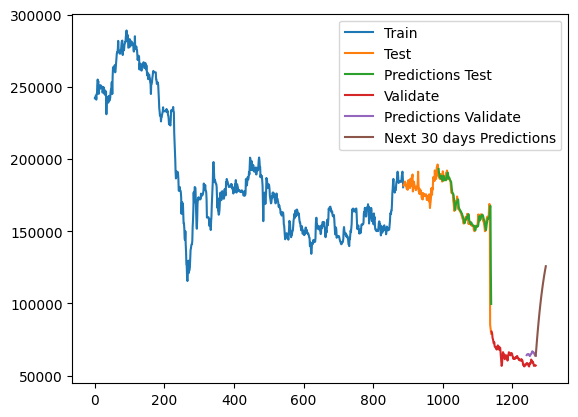

In [108]:
#Ve hinh
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predictions Test','Validate','Predictions Validate','Next 30 days Predictions'])

plt.show()

<h1>Split the data into training, testing, and validation sets (6:3:1)

In [109]:
train_size = int(0.6 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

In [110]:
train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

<h1>Create dataset

In [111]:
#Chuyển mảng giá trị của dataset thành ma trận
def create_dataset(dataset, time_step = 1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   #i=0, X=0,1,2,3...99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [112]:
import numpy
#Reshape into X=t,t+1, t+2... t+99 and Y= t+100
time_step =100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [113]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [114]:
#Define GRU model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [115]:
#Fit the model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
11/11 [==============================] - 64s 347ms/step - loss: 0.1343 - val_loss: 0.0032
Epoch 2/100
11/11 [==============================] - 2s 206ms/step - loss: 0.0179 - val_loss: 0.0101
Epoch 3/100
11/11 [==============================] - 1s 127ms/step - loss: 0.0054 - val_loss: 0.0025
Epoch 4/100
11/11 [==============================] - 1s 100ms/step - loss: 0.0050 - val_loss: 0.0019
Epoch 5/100
11/11 [==============================] - 2s 145ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 6/100
11/11 [==============================] - 1s 108ms/step - loss: 0.0026 - val_loss: 0.0015
Epoch 7/100
11/11 [==============================] - 1s 122ms/step - loss: 0.0023 - val_loss: 0.0017
Epoch 8/100
11/11 [==============================] - 1s 113ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 9/100
11/11 [==============================] - 1s 130ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 10/100
11/11 [==============================] - 2s 163ms/step - loss: 0.0013 - val_l

<h1> Du bao du lieu test, val

In [116]:
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

1/1 [==============================] - 0s 32ms/step


In [117]:
#Chuan hoa du lieu cua y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [118]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
ytest

array([[179056.],
       [177487.],
       [176703.],
       [178468.],
       [178468.],
       [178468.],
       [182390.],
       [184352.],
       [184842.],
       [189745.],
       [191216.],
       [190235.],
       [186313.],
       [183371.],
       [183861.],
       [184352.],
       [184352.],
       [184254.],
       [184254.],
       [184352.],
       [184940.],
       [184352.],
       [187980.],
       [190039.],
       [191216.],
       [187293.],
       [180429.],
       [181704.],
       [181704.],
       [181704.],
       [183861.],
       [184352.],
       [183371.],
       [183371.],
       [181410.],
       [181704.],
       [179449.],
       [179252.],
       [181410.],
       [178664.],
       [184352.],
       [185332.],
       [182194.],
       [183371.],
       [180919.],
       [179939.],
       [179939.],
       [186313.],
       [184744.],
       [181508.],
       [186117.],
       [187195.],
       [187588.],
       [189255.],
       [177487.],
       [18

In [119]:
yval = scaler.inverse_transform(yval.reshape(-1,1))
yval

array([[58400.],
       [58000.],
       [57900.],
       [58600.],
       [58100.],
       [58000.],
       [57100.],
       [56600.],
       [56300.],
       [57700.],
       [58500.],
       [58600.],
       [58300.],
       [58900.],
       [61100.],
       [60600.],
       [60000.],
       [59300.],
       [59100.],
       [59600.],
       [58700.],
       [58000.],
       [56700.],
       [56900.],
       [56900.],
       [57200.],
       [57200.]])

<h1>Evaluate the accuracy of the algorithm

In [120]:
#Tính RMSE, MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAE
valid_mae = mean_absolute_error(yval,y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

#MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval))*100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest))*100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 4674.379941082923
Testing RMSE: 6147.739600207786
Validation MAE: 4579.768373842594
Testing MAE: 2455.6832717293873
Validation MAPE: 7.88934529549124
Testing MAPE: 1.709654554843402


<h1>Du doan co phieu trong 30 ngay tiep theo

In [121]:
x_input=val_data[28:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input)
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

[0.02328552]
101
1 day input [0.00171895 0.00472712 0.02191663 0.03266008 0.04254405 0.03781693
 0.03781693 0.03266008 0.02621401 0.02148689 0.02449506 0.02965191
 0.03394929 0.0318006  0.02879244 0.02922217 0.03094113 0.01761925
 0.02879244 0.03437903 0.03695746 0.04254405 0.03738719 0.03738719
 0.03609798 0.03308982 0.03824667 0.03996562 0.03996562 0.03953588
 0.03738719 0.03308982 0.02879244 0.02793296 0.02234637 0.02535453
 0.02449506 0.02449506 0.02234637 0.02449506 0.02750322 0.0249248
 0.02535453 0.02879244 0.03094113 0.03094113 0.02621401 0.02406532
 0.0249248  0.02277611 0.0193382  0.02191663 0.02062742 0.01761925
 0.01761925 0.01761925 0.01804899 0.02191663 0.01976794 0.01718951
 0.01718951 0.01074345 0.00429738 0.00687581 0.00386764 0.
 0.00515685 0.00300817 0.00300817 0.00429738 0.00644607 0.0090245
 0.00730554 0.00687581 0.00988397 0.00773528 0.00730554 0.0034379
 0.00128921 0.         0.00601633 0.00945423 0.00988397 0.00859476
 0.01117318 0.02062742 0.01847873 0.0159003 

In [122]:
print(scaler.inverse_transform(lst_output))

[[ 61718.54034849]
 [ 63456.64650053]
 [ 65306.83699623]
 [ 67169.96386833]
 [ 69008.17761831]
 [ 70808.94149914]
 [ 72568.21760684]
 [ 74284.82785821]
 [ 75958.70463699]
 [ 77590.34206197]
 [ 79180.52552193]
 [ 80730.1964432 ]
 [ 82240.36386833]
 [ 83712.06631362]
 [ 85146.35443166]
 [ 86544.24419999]
 [ 87906.74986243]
 [ 89234.84752029]
 [ 90529.49420363]
 [ 91791.61920249]
 [ 93022.12753445]
 [ 94221.88954204]
 [ 95391.76169783]
 [ 96532.56926686]
 [ 97645.10977417]
 [ 98730.15993983]
 [ 99788.46874386]
 [100820.77129632]
 [101827.77496725]
 [102810.15245169]]


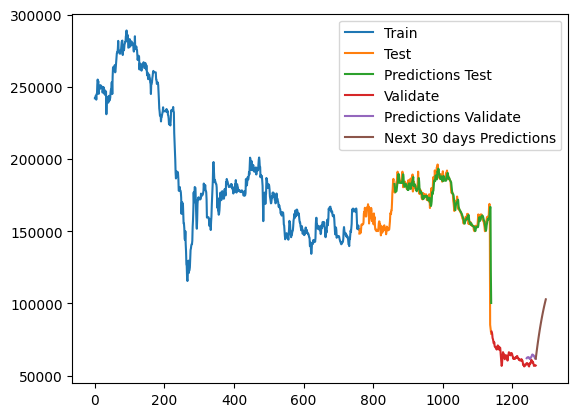

In [123]:
#Ve hinh
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predictions Test','Validate','Predictions Validate','Next 30 days Predictions'])

plt.show()

<h1>Split the data into training, testing, and validation sets (5:3:2)

In [124]:
train_size = int(0.5 * len(df1))
test_size = int(0.3 * len(df1))
val_size = len(df1) - train_size - test_size

In [125]:
train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

<h1> Create dataset

In [126]:
#Chuyển mảng giá trị của dataset thành ma trận
def create_dataset(dataset, time_step = 1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   #i=0, X=0,1,2,3...99   Y=100
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [127]:
import numpy
#Reshape into X=t,t+1, t+2... t+99 and Y= t+100
time_step =100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [128]:
#Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [129]:
#Define GRU model
model = Sequential()
model.add(GRU(64, input_shape=(time_step, 1)))
model.add(Dense(1))
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [130]:
#Fit the model
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
9/9 [==============================] - 4s 117ms/step - loss: 0.2756 - val_loss: 0.0469
Epoch 2/100
9/9 [==============================] - 1s 62ms/step - loss: 0.0310 - val_loss: 0.0166
Epoch 3/100
9/9 [==============================] - 1s 61ms/step - loss: 0.0218 - val_loss: 0.0108
Epoch 4/100
9/9 [==============================] - 1s 60ms/step - loss: 0.0059 - val_loss: 8.8268e-04
Epoch 5/100
9/9 [==============================] - 1s 61ms/step - loss: 0.0076 - val_loss: 8.1089e-04
Epoch 6/100
9/9 [==============================] - 1s 61ms/step - loss: 0.0049 - val_loss: 0.0024
Epoch 7/100
9/9 [==============================] - 1s 64ms/step - loss: 0.0044 - val_loss: 0.0027
Epoch 8/100
9/9 [==============================] - 1s 60ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 9/100
9/9 [==============================] - 1s 62ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 10/100
9/9 [==============================] - 1s 97ms/step - loss: 0.0030 - val_loss: 0.0012
Epoch 11/1

<h1>Du bao du lieu test, val

In [131]:
train_predict = model.predict(X_train)
y_pred = model.predict(X_test)
y_pred_val = model.predict(X_val)

5/5 [==============================] - 0s 12ms/step


In [132]:
#Chuan hoa du lieu cua y_pred, y_pred_val
train_predict = scaler.inverse_transform(train_predict)
y_pred = scaler.inverse_transform(y_pred)
y_pred_val = scaler.inverse_transform(y_pred_val)

In [133]:
ytest = scaler.inverse_transform(ytest.reshape(-1,1))
ytest

array([[147817.],
       [150440.],
       [149469.],
       [152579.],
       [155105.],
       [163172.],
       [165212.],
       [163657.],
       [165698.],
       [164629.],
       [164824.],
       [163657.],
       [165018.],
       [164921.],
       [164824.],
       [165018.],
       [163269.],
       [165720.],
       [163857.],
       [156895.],
       [151600.],
       [152580.],
       [151992.],
       [153953.],
       [151011.],
       [151011.],
       [148364.],
       [151011.],
       [151011.],
       [148560.],
       [149246.],
       [151011.],
       [154443.],
       [154738.],
       [154443.],
       [154542.],
       [154934.],
       [154836.],
       [155914.],
       [162092.],
       [163269.],
       [162975.],
       [166211.],
       [163269.],
       [161013.],
       [160131.],
       [160327.],
       [163661.],
       [165328.],
       [166701.],
       [165622.],
       [168662.],
       [166407.],
       [166995.],
       [155326.],
       [16

In [134]:
yval = scaler.inverse_transform(yval.reshape(-1,1))
yval

array([[159500.],
       [158000.],
       [157300.],
       [157300.],
       [155700.],
       [153600.],
       [152700.],
       [150000.],
       [150100.],
       [153500.],
       [156200.],
       [156300.],
       [158100.],
       [159800.],
       [158000.],
       [158800.],
       [159000.],
       [160500.],
       [160600.],
       [167500.],
       [168900.],
       [166800.],
       [ 85200.],
       [ 83100.],
       [ 80800.],
       [ 79000.],
       [ 80500.],
       [ 80000.],
       [ 78600.],
       [ 76000.],
       [ 75300.],
       [ 74100.],
       [ 72400.],
       [ 72500.],
       [ 73000.],
       [ 70300.],
       [ 70000.],
       [ 69500.],
       [ 69600.],
       [ 68800.],
       [ 68800.],
       [ 68000.],
       [ 68900.],
       [ 70100.],
       [ 70900.],
       [ 69900.],
       [ 68300.],
       [ 68300.],
       [ 70000.],
       [ 67800.],
       [ 69100.],
       [ 69200.],
       [ 66200.],
       [ 63100.],
       [ 60800.],
       [ 5

<h1>Evaluate the accuracy of the algorithm

In [135]:
#Tính RMSE, MAE, MAPE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

#MAE
valid_mae = mean_absolute_error(yval,y_pred_val)
test_mae = mean_absolute_error(ytest, y_pred)
print('Validation MAE:', valid_mae)
print('Testing MAE:', test_mae)

#MAPE
valid_mape = np.mean(np.abs((yval - y_pred_val) / yval))*100
test_mape = np.mean(np.abs((ytest - y_pred) / ytest))*100
print('Validation MAPE:', valid_mape)
print('Testing MAPE:', test_mape)

Validation RMSE: 11623.231328914384
Testing RMSE: 3534.6011984237925
Validation MAE: 8737.930453431372
Testing MAE: 2640.735439068096
Validation MAPE: 13.193116602187988
Testing MAPE: 1.5388204687009708


<h1>Du doan co phieu trong 30 ngay tiep theo

In [136]:
x_input=val_data[28:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=100
i=0
while i < 30:
    if len(temp_input) > 100:
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = np.array(temp_input)
        x_input = x_input.reshape(1, -1, 1)
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i += 1

0 day input [0.47400086 0.46927374 0.47357112 0.46755479 0.46798453 0.46497636
 0.46239794 0.46325741 0.4585303  0.45638161 0.45552213 0.44864633
 0.44864633 0.44134078 0.43919209 0.4370434  0.42629996 0.42544048
 0.42844865 0.4370434  0.43790288 0.4370434  0.44305973 0.44563816
 0.44477869 0.44477869 0.4370434  0.45423292 0.45337344 0.45423292
 0.44134078 0.42415127 0.43188655 0.42544048 0.42415127 0.42329179
 0.43059734 0.42844865 0.42157284 0.42286205 0.41985389 0.41813494
 0.41856468 0.41813494 0.41899441 0.41727546 0.40696175 0.40395359
 0.40266437 0.40696175 0.4177052  0.41899441 0.4177052  0.41598625
 0.41469703 0.41641599 0.41598625 0.42415127 0.4370434  0.45251397
 0.44649764 0.43274602 0.43188655 0.43876235 0.44091104 0.45208423
 0.44778685 0.44993554 0.45251397 0.44993554 0.44821659 0.44348947
 0.4370434  0.43403524 0.43403524 0.42715943 0.41813494 0.4142673
 0.40266437 0.40309411 0.4177052  0.42930812 0.42973786 0.43747314
 0.44477869 0.4370434  0.44048131 0.44134078 0.4477

In [137]:
print(scaler.inverse_transform(lst_output))

[[ 66224.9018874 ]
 [ 68552.61744075]
 [ 71632.888899  ]
 [ 74770.89683637]
 [ 77815.39842933]
 [ 80735.36821976]
 [ 83526.50477365]
 [ 86191.50580615]
 [ 88735.38879007]
 [ 91163.94618452]
 [ 93483.12475234]
 [ 95698.6562714 ]
 [ 97816.07140452]
 [ 99840.52285701]
 [101776.88246667]
 [103629.76200879]
 [105403.4126386 ]
 [107101.90520138]
 [108729.01580483]
 [110288.31250668]
 [111783.15878212]
 [113216.68925136]
 [114591.91023707]
 [115911.60614192]
 [117178.40186357]
 [118394.82174218]
 [119563.20980787]
 [120685.7783258 ]
 [121764.62166607]
 [122801.73710883]]


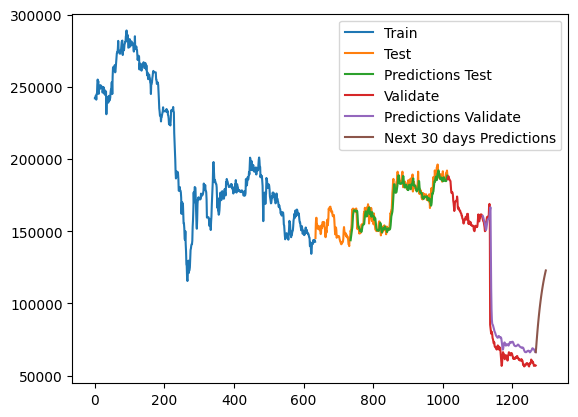

In [138]:
#Ve hinh
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))

test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))

test_data_index = pd.RangeIndex(start=train_size+101, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))

val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))

val_data_index = pd.RangeIndex(start=train_size+test_size+101, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)

prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predictions Test','Validate','Predictions Validate','Next 30 days Predictions'])

plt.show()